# E02. Building dataset for MODIS 2000-2012 

#### 0. Load required libraries, site dependant constants and utility functions.

In [1]:
from os import listdir
from os.path import isfile, join
import numpy as np
import seaborn as sns


# EOLearn libraries:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, LoadTask, SaveTask, FeatureType, EOExecutor
from eolearn.core import OverwritePermission

# Add to python path parent dictionary
import sys
sys.path.append("../../")

# load site dependant constants (HERE YOU CAN CHOOSE DIFFERENT LOCATION)
from aoi_sites import upe_promice_area as site

# load utility functions
from utils import io_functions as io_utils
from utils import plot_functions as plot_utils

#### 1. Define  EOTASKs

In [2]:
class ConcatenateDataByDataName(EOTask):
    """Task to concatenate data arrays along the last dimension"""
    def __init__(self, data_names_to_ctn, data_timeless_names_to_ctn, dataset_name):
        self.data_names_to_ctn = data_names_to_ctn
        self.data_timeless_names_to_ctn = data_timeless_names_to_ctn
        self.dataset_name = dataset_name

    def execute(self, eopatch):
        arrays = [eopatch.data[name] for name in self.data_names_to_ctn]
        arrays_timeless = [eopatch.data_timeless[name] for name in self.data_timeless_names_to_ctn]
 
        if len(arrays) == 0:
            concatenated_dataset = np.concatenate(arrays_timeless, axis=-1)[np.newaxis, ...]
        else:
            array_shape = arrays[-1].shape
            for arr_timeless in arrays_timeless:
                arrays.append(np.repeat(arr_timeless[np.newaxis, :,:,: ], array_shape[0], axis=0))
        
        eopatch.add_feature(FeatureType.DATA, self.dataset_name, np.concatenate(arrays, axis=-1) )
        return eopatch

#### 2. Build EOTASKs

In [6]:
# load exemplary eo patch for testing
eo_patch = io_utils.load_exemplary_eopatch(data_product='MODIS',date_range = site.DATE_RANGES_MODIS[5], patch_id=6, random_choice=True)
eo_patch

Loaded from ../../data/EOPatches/MODIS/UPE_PROMICE/UTM_22N/2018_04-2018_11/3310_maxcc_0.05_x-6_y-134


EOPatch(
  data: {
    MODIS_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(194, 333, 333, 1), dtype=float32)
    MODIS_NDWI: numpy.ndarray(shape=(194, 333, 333, 1), dtype=float32)
    MODIS_NRB: numpy.ndarray(shape=(194, 333, 333, 1), dtype=float32)
    MODIS_RAW_BANDS: numpy.ndarray(shape=(194, 333, 333, 7), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(194, 333, 333, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM_RAW_LAYER: numpy.ndarray(shape=(333, 333, 1), dtype=float32)
    DEM_SLOPE_LAYER: numpy.ndarray(shape=(333, 333, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    index_x: 6
    index_y: 134
    maxcc: '0.05'
    patch_index: 3310
    service_type: 'wcs'
    site_name: 'UPE_PROMICE'
    size_x: '30m'
    size_y: '30m'
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: ('2018-04-26', '2018-11-05')
  }
  bbox: BBox(((430000.0, 807

In [27]:
list_of_data_names = ['MODIS_RAW_BANDS_DAY_0', 'MODIS_EUC_NORM_RAW_BANDS', 'MODIS_NDWI', 'MODIS_NRB']
list_of_timeless_data = ['DEM_SLOPE_LAYER']
dataset_name='DATASET'
concatenate_eotask = ConcatenateDataByDataName(data_names_to_ctn=list_of_data_names, data_timeless_names_to_ctn=list_of_timeless_data  ,dataset_name = dataset_name)

#### 3. Test EOTASK

In [28]:
concatenate_eotask(eo_patch)

EOPatch(
  data: {
    DATASET_CLD_200_dil_6_str2: numpy.ndarray(shape=(7, 333, 333, 11), dtype=float32)
    LANDSAT_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_GREEN_NIR: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_ICE: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_NIR_SWIR_1: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    LANDSAT_NDWI_NIR_SWIR_2: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    LANDSAT_QA_LAYERS: numpy.ndarray(shape=(7, 333, 333, 5), dtype=float32)
    LANDSAT_RAW_BANDS: numpy.ndarray(shape=(7, 333, 333, 11), dtype=float32)
    MODIS_EUC_NORM_RAW_BANDS: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    MODIS_NDWI: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    MODIS_NRB: numpy.ndarray(shape=(7, 333, 333, 1), dtype=float32)
    MODIS_RAW_BANDS_DAY_0: numpy.ndarray(shape

2013-09-14 15:26:31
Ploting...


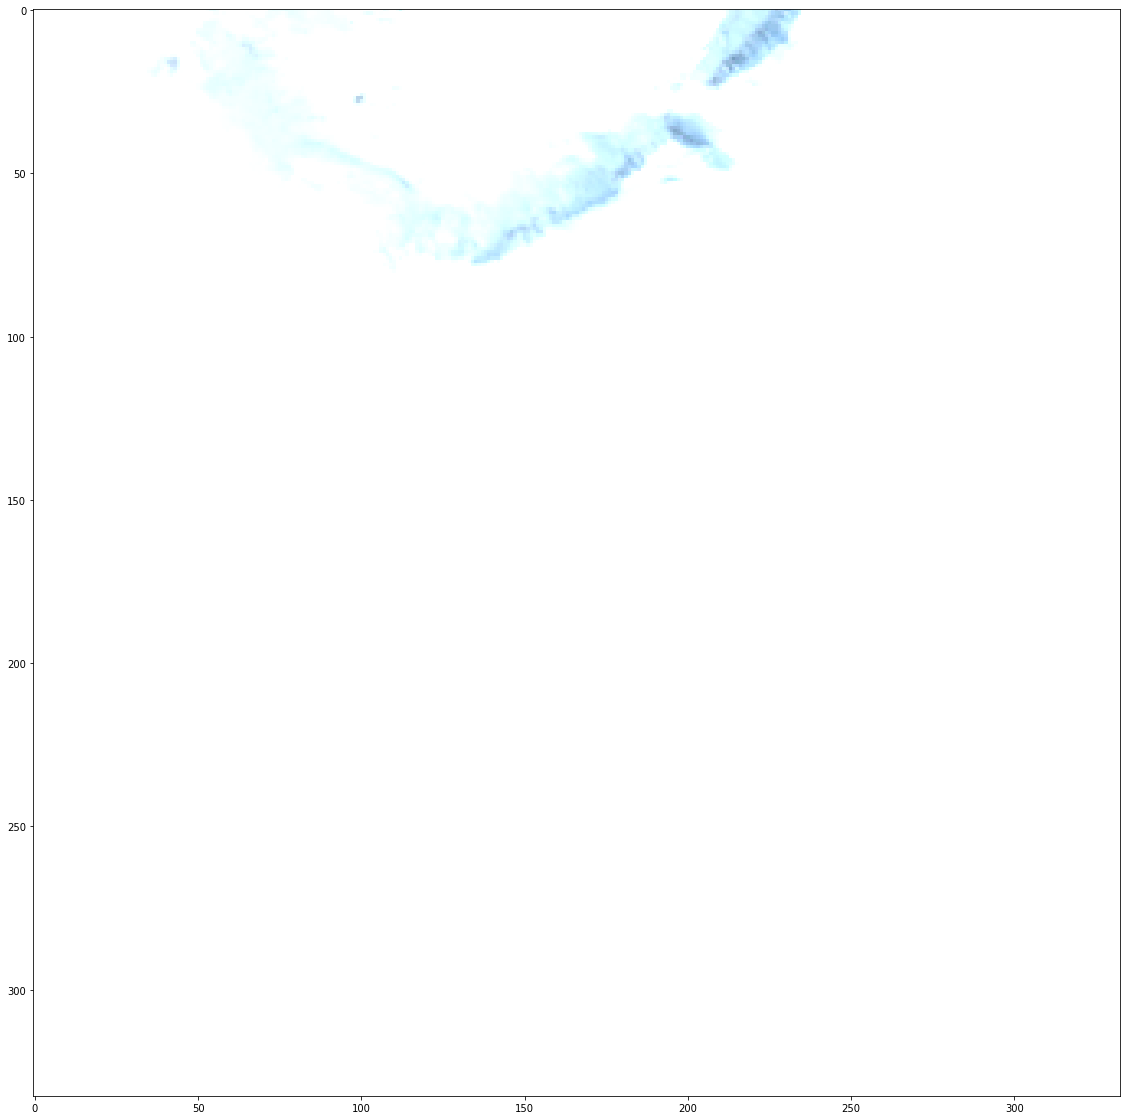

In [36]:
# check the random eopatch
plot_utils.plot_RGB_LANDSAT_8_image(eo_patch, datetime_idx=2)

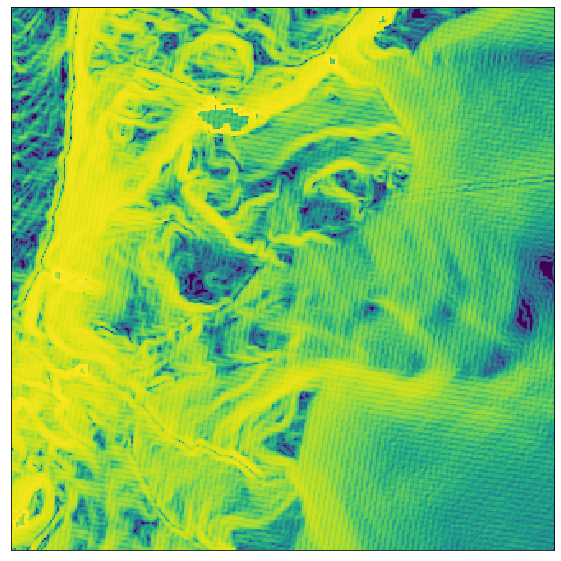

In [38]:
# check first picture to see if DEM model looks good (cut out boundary rows and columns bc slope -999999 - nothing to see in the picture):
plot_utils.plot_matrix(eo_patch.data['DATASET_CLD_200_dil_6_str2'][0][..., 10][1:332, 1:332])

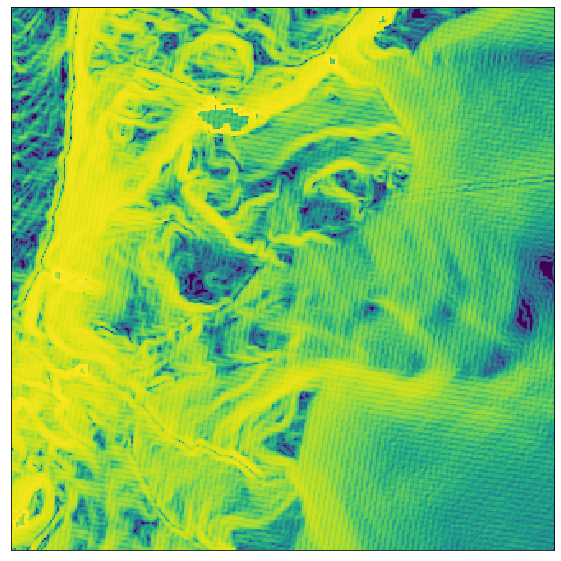

In [37]:
# check anohter day to see if dem looks the same
plot_utils.plot_matrix(eo_patch.data['DATASET_CLD_200_dil_6_str2'][1][..., 10][1:332, 1:332])

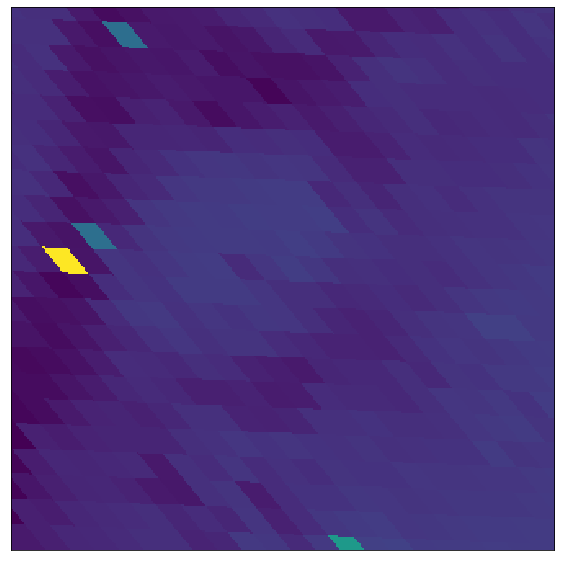

In [42]:
# check any other band
plot_utils.plot_matrix(eo_patch.data['DATASET_CLD_200_dil_6_str2'][1][..., 7])

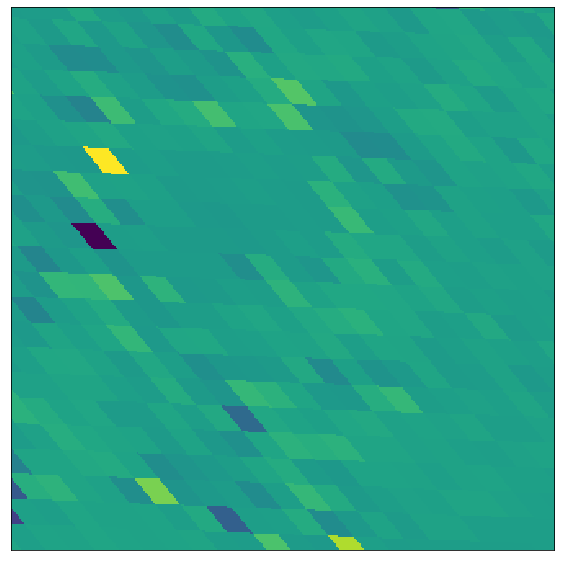

In [40]:
# check any other band
plot_utils.plot_matrix(eo_patch.data['DATASET_CLD_200_dil_6_str2'][1][..., 8])

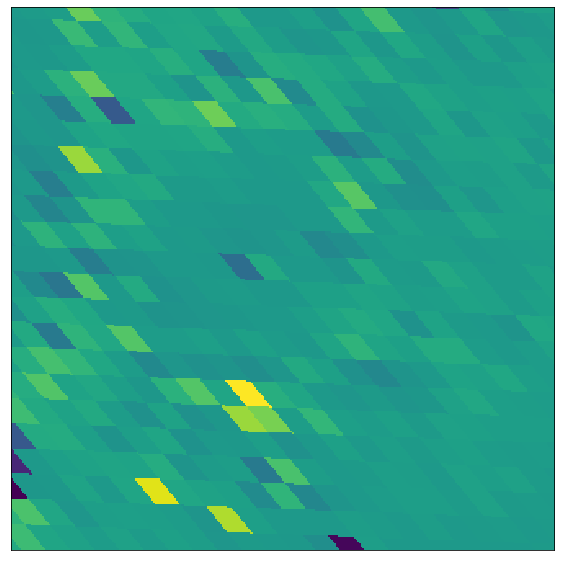

In [41]:
# check any other band
plot_utils.plot_matrix(eo_patch.data['DATASET_CLD_200_dil_6_str2'][1][..., 9])

#### 3. Apply EOWORKFLOW

In [43]:
# application dataset building eotasks for all aval eopatches in the a eoworkflow
for date_range_landsat in site.DATE_RANGES_LANDSAT_8 :
    print('Reading EOPatches from:', date_range_landsat)
    eopatches_filepath = io_utils.get_eopatches_dir(site.DATA_PRODUCTS[1], site.SITE_NAME, site.AVAILABLE_CRSs[0], date_range_landsat)
    # TASK TO LOAD AND SAVE EXISTING EOPATCHES HAS TO BE CREATED YEARLY (different directories)
    load_eotask = LoadTask(eopatches_filepath)
    save_eotask = SaveTask(eopatches_filepath, overwrite_permission=OverwritePermission.OVERWRITE_PATCH, compress_level=1)
    
    # Define the workflow
    workflow = LinearWorkflow(
    load_eotask,
    concatenate_eotask,
    save_eotask
    )
                      
    list_of_available_patches = io_utils.get_list_of_eopatches(eopatches_filepath)
    execution_args = []
    for eopatch_name in list_of_available_patches:
        execution_args.append({
        load_eotask: {'eopatch_folder': eopatch_name},
        save_eotask: {'eopatch_folder': eopatch_name}
        })
    
    #print(execution_args)                            
    executor = EOExecutor(workflow, execution_args, save_logs=True)
    executor.run(workers=1, multiprocess=False)

    executor.make_report()

Reading EOPatches from: ('2013-05-01', '2013-10-31')


C:\Users\Kamil\Anaconda3\lib\site-packages\jinja2\utils.py:485: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
C:\Users\Kamil\Anaconda3\lib\site-packages\holoviews\core\data\grid.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import OrderedDict, defaultdict, Iterable
C:\Users\Kamil\Anaconda3\lib\site-packages\holoviews\operation\datashader.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Callable, Iterable
C:\Users\Kamil\Anaconda3\lib\site-packages\numba\npyufunc\dufunc.py:86: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargs

Reading EOPatches from: ('2014-05-01', '2014-10-31')



Reading EOPatches from: ('2015-05-01', '2015-10-31')



Reading EOPatches from: ('2016-05-01', '2016-10-31')



Reading EOPatches from: ('2017-05-01', '2017-10-31')



Reading EOPatches from: ('2018-05-01', '2018-10-31')



Reading EOPatches from: ('2019-05-01', '2019-10-31')


#### 4. Takeaway

11 features are included, MODIS bands, eucledian norm, 2 NDWI and  slope derived from DEM, 